In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sbn 
import datetime
from DR_generator import *
import statsmodels.api as sm

# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='onedork')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

# Summary 

The purpose of this script is to generate a dataset that we can use to test the impact of replicates on AUC measurements. 

#### Step 1: Generate non-hermetic dataset with replicates n=1:5 

#### Step 2: Calculate AUC of underlying curve 

#### Step 3: Fit logistic regression curve to data and calculate AUC 

#### Step 4: Compare error 
$$ error = AUC_{true} - AUC_{fitted} $$ 


In [4]:
batch_size = 500
noise = 0.1
plot=False

mygen1 = hermetic_generator(s = noise, b1range=(-10, 0), mrange= (0,0.5), b0range=(-10,-6), trange=(11,15), dose_points = [10/(3**i) for i in range(0,7)])
syn_data1 = mygen1.get(n=batch_size, nn=1, plot=plot)
print()
mygen2 = hermetic_generator(s = noise, b1range=(-10, 0), mrange= (0,0.5), b0range=(-10,-6), trange=(11,15), dose_points = [10/(3**i) for i in range(0,7)])
syn_data2 = mygen2.get(n=batch_size, nn=2, plot=plot)
print()
mygen3 = hermetic_generator(s = noise, b1range=(-10, 0), mrange= (0,0.5), b0range=(-10,-6), trange=(11,15), dose_points = [10/(3**i) for i in range(0,7)])
syn_data3 = mygen3.get(n=batch_size, nn=3, plot=plot)

print()
mygen4 = hermetic_generator(s = noise, b1range=(-10, 0), mrange= (0,0.5), b0range=(-10,-6), trange=(11,15), dose_points = [10/(3**i) for i in range(0,7)])
syn_data4 = mygen4.get(n=batch_size, nn=4, plot=plot)
print()
mygen5 = hermetic_generator(s = noise, b1range=(-10, 0), mrange= (0,0.5), b0range=(-10,-6), trange=(11,15), dose_points = [10/(3**i) for i in range(0,7)])
syn_data5 = mygen5.get(n=batch_size, nn=5, plot=plot)
print()

repl_data = syn_data1.append([syn_data2, syn_data3, syn_data4, syn_data5], ignore_index=True)
repl_data.head()

,t,b1,b0,m,b,s,DOSE_10.00,DOSE_3.33,DOSE_1.11,DOSE_0.37,DOSE_0.12,DOSE_0.04,DOSE_0.01,id
0,12.022369,-6.562591,-8.353609,0.152650,-0.164860,0.1,0.259028,0.020229,-0.126583,-0.106401,0.161970,0.686920,0.946027,MT19937_01:43:11.564321_1
1,11.165371,-2.674197,-6.797454,0.124938,-0.130852,0.1,-0.016768,-0.082579,-0.050996,-0.001608,0.013132,0.185199,0.093952,MT19937_01:43:11.566354_1
2,11.217572,-1.732484,-6.899959,0.356106,-0.373712,0.1,0.044508,-0.246426,-0.033353,-0.043123,0.080122,0.052223,0.032316,MT19937_01:43:11.569305_1
3,12.615020,-5.866661,-8.878546,0.171253,-0.188530,0.1,-0.103178,-0.155761,-0.114877,-0.194798,-0.100236,0.511735,1.012471,MT19937_01:43:11.571299_1
4,14.065818,-8.600331,-6.866017,0.046634,-0.053544,0.1,0.011041,-0.037537,-0.012505,-0.028362,0.620880,1.060935,0.994760,MT19937_01:43:11.573299_1


In [5]:
def logistic_AUC(b0, b1, lower=10/3**6, upper=10, delta=0.001): 
    '''
    integrating the logistic equation, we calculate the closeform solution to get AUC from min conc (lower) to max conc (upper) given a pair of parameters. 
    
    P_i(c) =   1/(1+exp(-(b0 + b1*c)))
        where, 
            c = concentration 
            b0 = intercept param. 
            b1 = slope param.
    '''
    #logit = lambda x: 1/(1 + np.exp(-(b0 + b1*x)))
    #x = np.arange(lower, upper, delta)
    
    AUC = 0
    for x in np.arange(np.log10(lower), np.log10(upper), delta): AUC += (1/(1 + np.exp(-(b0 + b1*(x)))))*delta
    #AUC = np.sum(logit(x)*delta)
    #AUC = (upper - np.log(np.exp(b1*upper-b0) + 1)/b1) - (lower - np.log(np.exp(b1*lower-b0) + 1)/b1)
    return AUC 

In [6]:
logistic_AUC(2,3)

1.6596014843812907

In [7]:
repl_data = repl_data.assign(AUC_true = lambda x: logistic_AUC(x.b0, x.b1))
repl_data.head()

,t,b1,b0,m,b,s,DOSE_10.00,DOSE_3.33,DOSE_1.11,DOSE_0.37,DOSE_0.12,DOSE_0.04,DOSE_0.01,id,AUC_true
0,12.022369,-6.562591,-8.353609,0.152650,-0.164860,0.1,0.259028,0.020229,-0.126583,-0.106401,0.161970,0.686920,0.946027,MT19937_01:43:11.564321_1,0.593447
1,11.165371,-2.674197,-6.797454,0.124938,-0.130852,0.1,-0.016768,-0.082579,-0.050996,-0.001608,0.013132,0.185199,0.093952,MT19937_01:43:11.566354_1,0.056395
2,11.217572,-1.732484,-6.899959,0.356106,-0.373712,0.1,0.044508,-0.246426,-0.033353,-0.043123,0.080122,0.052223,0.032316,MT19937_01:43:11.569305_1,0.014390
3,12.615020,-5.866661,-8.878546,0.171253,-0.188530,0.1,-0.103178,-0.155761,-0.114877,-0.194798,-0.100236,0.511735,1.012471,MT19937_01:43:11.571299_1,0.370433
4,14.065818,-8.600331,-6.866017,0.046634,-0.053544,0.1,0.011041,-0.037537,-0.012505,-0.028362,0.620880,1.060935,0.994760,MT19937_01:43:11.573299_1,1.064896


In [8]:
def calc_AUC_from_replicates(D, conc = [10/(3**i) for i in range(0,7)]): 
    '''
    1. Fit logistic equation 
    2. Calculate AUC 
    3. return AUC 
    
    D <data.frame> 
        Expects (repl, 7), with decreasing dose
    '''

    D = pd.melt(D, var_name='conc', value_name='cell_viab')
    x = sm.add_constant(np.log10(D['conc'].values))
    y = np.array([max(min(x, 1), 0) for x in D['cell_viab'].values])
    
    try: 
        pr = sm.GLM(y, x, family=sm.families.Binomial(link=sm.families.links.logit()))
        res = pr.fit(disp=False)
    except: 
        return None, (None, None) 
    
    return logistic_AUC(*res.params), res.params
    

In [9]:
key = ['t','b1','b0','m','b','s']
uniq = repl_data[key].drop_duplicates()

res = {x:[] for x in key + ['AUC_synth', 'replicates',  'b0_synth', 'b1_synth']}
for i,row in enumerate(uniq.values):
    print(f'fitting regressions [{100*i/uniq.shape[0]}%]', end='\r')
    assay = repl_data[ [np.all(x == row) for x in repl_data[key].values] ] 
    replicates = assay.shape[0]
    D = pd.DataFrame(assay.values[0:3, 6:(6+7)]).rename({x:y for x,y in enumerate([10/(3**i) for i in range(0,7)])}, axis=1)
    AUC, (b0, b1) = calc_AUC_from_replicates(D)
    [res[x].append(y) for x,y in zip(key + ['AUC_synth', 'replicates', 'b0_synth', 'b1_synth'], list(row) + [AUC, replicates,b0,b1])]

repl_data = pd.merge(repl_data, pd.DataFrame(res), on=key, how='left')
repl_data = repl_data.assign(se = lambda x: (x.AUC_true - x.AUC_synth)**2)
repl_data.head()


C:\anaconda-3.5.2.0\lib\site-packages\statsmodels\genmod\families\family.py:880: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


,t,b1,b0,m,b,s,DOSE_10.00,DOSE_3.33,DOSE_1.11,DOSE_0.37,DOSE_0.12,DOSE_0.04,DOSE_0.01,id,AUC_true,AUC_synth,replicates,b0_synth,b1_synth,se
0,12.022369,-6.562591,-8.353609,0.152650,-0.164860,0.1,0.259028,0.020229,-0.126583,-0.106401,0.161970,0.686920,0.946027,MT19937_01:43:11.564321_1,0.593447,0.798483,1,-2.131020,-1.762822,0.042040
1,11.165371,-2.674197,-6.797454,0.124938,-0.130852,0.1,-0.016768,-0.082579,-0.050996,-0.001608,0.013132,0.185199,0.093952,MT19937_01:43:11.566354_1,0.056395,0.094789,1,-5.166629,-1.906799,0.001474
2,11.217572,-1.732484,-6.899959,0.356106,-0.373712,0.1,0.044508,-0.246426,-0.033353,-0.043123,0.080122,0.052223,0.032316,MT19937_01:43:11.569305_1,0.014390,0.084239,1,-3.714815,-0.392823,0.004879
3,12.615020,-5.866661,-8.878546,0.171253,-0.188530,0.1,-0.103178,-0.155761,-0.114877,-0.194798,-0.100236,0.511735,1.012471,MT19937_01:43:11.571299_1,0.370433,NaN,1,NaN,NaN,NaN
4,14.065818,-8.600331,-6.866017,0.046634,-0.053544,0.1,0.011041,-0.037537,-0.012505,-0.028362,0.620880,1.060935,0.994760,MT19937_01:43:11.573299_1,1.064896,1.009948,1,-6.633917,-7.774155,0.003019


C:\anaconda-3.5.2.0\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


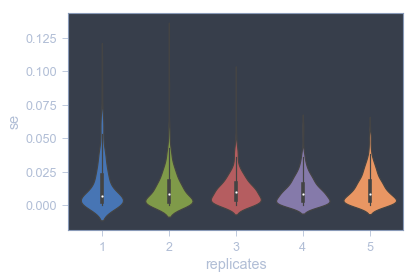

In [10]:
sbn.violinplot(x='replicates', y='se', data=repl_data[['replicates', 'se']].drop_duplicates())

In [11]:
repl_data[['replicates', 'se']].drop_duplicates().groupby('replicates').mean()['se']

replicates
1    0.015567
2    0.012902
3    0.012048
4    0.011168
5    0.012131
Name: se, dtype: float64

In [12]:
repl_data[['replicates', 'se']].drop_duplicates().groupby('replicates').count()

,se
replicates,
1,496
2,500
3,500
4,500
5,500


In [13]:
def plot_assay(D, lower=10/3**6, upper=10, delta=0.001, conc=[10/(3**i) for i in range(0,7)]): 
    '''
    '''
    b0 = D['b0'].unique()[0]
    b1 = D['b1'].unique()[0]
    b0s = D['b0_synth'].unique()[0]
    b1s = D['b1_synth'].unique()[0]
    
    print([b0,b1,b0s,b1s])
    
    logit = lambda x,b0,b1: 1/(1 + np.exp(-(b0 + b1*np.log10(x))))
    x = np.arange(lower, upper, delta)
    y = logit(x,b0,b1)
    y_synth = logit(x,b0s,b1s)
    
    df = pd.DataFrame(D.values[0:3, 6:(6+7)]).rename({x:y for x,y in zip(range(0,7), conc)}, axis=1).melt()
    conc = df['variable'].values
    cv = df['value'].values
    print(df)
    
    plt.figure()
    plt.plot(np.log10(x),y,'r-',label='truth')
    plt.plot(np.log10(x),y_synth, 'b-', label='synth')
    plt.plot(np.log10(conc), cv, 'b*', label='replicates')
    plt.ylim(0,1)
    plt.legend()
    plt.show()
    
    

In [19]:
key = ['t','b1','b0','m','b','s']
uniq = np.random.shuffle( repl_data[key].drop_duplicates() )[0:10]
print(uniq)
for i,row in enumerate(uniq):
    assay = repl_data[ [np.all(x == row) for x in repl_data[key].values] ] 
    plot_assay(D)

KeyError: 928